Underwater ring fault: confinement, mass rate, and pressure loss

In [3]:
# Require python>=3.9

In [4]:
%load_ext autoreload
%autoreload 2

In [5]:
# Config
import copy
import os
import numpy as np
from numpy.linalg import norm
import matplotlib
import matplotlib.pyplot as plt

# Path for ffmpeg (if animations are needed)
plt.rcParams['animation.ffmpeg_path'] = "C:\\Users\\Fredric\\Documents\\ffmpeg\\ffmpeg-n4.4-latest-win64-gpl-4.4\\bin\\ffmpeg.exe"

# Path for .pkl files output
# target_dir = "C:\\Users\\Fredric\\Documents\\Volcano\\quail_volcano\\scenarios\\tungurahua\\"
target_dir = "C:\\Users\\Fredric\\Documents\\Volcano\\quail_volcano\\scenarios\\entrainment\\"
# target_dir = "C:\\Users\\Fredric\\Documents\\Volcano\\quail_volcano\\scenarios\\results_dx4m\\"

# Path for Quail source code
source_dir = "C:\\Users\\Fredric\\Documents\\Volcano\\quail_volcano\\src\\"

# Path for Quail entry point
quail_path = os.path.join(source_dir, "quail")

In [6]:
# Import quail modules
os.chdir(source_dir)
import argparse
import importlib
import sys
import scipy

import defaultparams as default_deck
import errors
from general import ShapeType, SolverType, PhysicsType

import meshing.common as mesh_common
import meshing.gmsh as mesh_gmsh
import meshing.tools as mesh_tools

import numerics.helpers.helpers as helpers
import numerics.timestepping.tools as stepper_tools

import physics.zerodimensional.zerodimensional as zerod
import physics.euler.euler as euler
import physics.navierstokes.navierstokes as navierstokes
import physics.scalar.scalar as scalar
import physics.chemistry.chemistry as chemistry
import physics.multiphasevpT.multiphasevpT as multiphasevpT
import physics.multiphaseWLMA.multiphaseWLMA as multiphaseWLMA
import physics.multiphaseWLMA.iapws95_light.mixtureWLMA as mixtureWLMA

import processing.readwritedatafiles as readwritedatafiles
import processing.post as post
import processing.plot as plot
import processing
import processing.mdtools as mdtools

import solver.DG as DG
import solver.ADERDG as ADERDG
import solver.tools as solver_tools

import time
import multiprocessing as mp
from multidomain import Domain, Observer

from types import SimpleNamespace

os.chdir(target_dir)

### Data prep

In [7]:
# Default physics backend construction
wlma = mixtureWLMA.WLMA()

In [73]:
file_name_i = lambda i: f"ringfault_above_ocean_vent_region_{i}.pkl" #
file_name_i = lambda i: f"ringfault_above_ocean_vent_region2_{i}.pkl" #
file_name_i = lambda i: f"ringfault_above_ocean_vent_region3_{i}.pkl" #
file_name_i = lambda i: f"ringfault_above_ocean_vent_region4_{i}.pkl" #
file_name_i = lambda i: f"ringfault_above_ocean_vent_region4_1175plus_{i}.pkl" #

solver_from = lambda i: readwritedatafiles.read_data_file(file_name_i(i))
solver_from_multi = lambda domidx, i: readwritedatafiles.read_data_file(file_name_i(i))
# Initial condition state
physics0 = solver_from_multi(1,0).physics
x, _ = mdtools.downsample(solver_from_multi(1,0))
U_ess = physics0.IC.get_state(physics0, x, 0.0)

In [74]:
solver = solver_from_multi(0, 0)
_A, _B = mdtools.downsample(solver, "pDensityA")
_B.shape, helpers.evaluate_state(
      solver.state_coeffs,
      solver.basis.basis_val).shape

((9525, 3, 1), (9525, 1, 9))

In [75]:
''' Data ingestion routine '''

def process_file(time_idx, domain_read_list, solver_read_callback, x=None) -> SimpleNamespace:
  ''' If x is provided, does not recompute the downsampled mesh points (element
  center).Otherwise, does it every time. '''
  cat_x = []
  cat_rho_mix = []
  cat_ya = []
  cat_yw = []
  cat_ym = []
  cat_u = []
  cat_v = []
  cat_steamfrac = []
  cat_rhow = []
  cat_p = []
  cat_T = []
  cat_psat = []
  cat_E = []
  cat_c = []
  cat_alphaw = []
  cat_aux = []

  # Read from dom_idx

  for dom_idx in domain_read_list:
    solver = solver_read_callback(dom_idx, time_idx)

    t = solver.time
    # JANK: manually reconstruct the downsampled conservative variables
    # x, _U0 = mdtools.downsample(solver, "pDensityA")
    # _, _U1 = mdtools.downsample(solver, "pDensityWv")
    # _, _U2 = mdtools.downsample(solver, "pDensityM")
    # _, _U3 = mdtools.downsample(solver, "XMomentum")
    # _, _U4 = mdtools.downsample(solver, "YMomentum")
    # _, _U5 = mdtools.downsample(solver, "Energy")
    # DEJANKED: manually process
    if x is None:
      original_order = solver.order
      solver.order = 0
      equidistant_pts = True
      x = processing.plot.get_sample_points(
        solver.mesh,
        solver,
        solver.physics,
        solver.basis,
        equidistant_pts)
      solver.order = original_order
    solver.order = 0
    Uq = helpers.evaluate_state(
      solver.state_coeffs,
      solver.basis.basis_val)
    # Extract and flatten for order = 0
    _U0 = Uq[...,0:1,0:1]
    _U1 = Uq[...,0:1,1:2]
    _U2 = Uq[...,0:1,2:3]
    _U3 = Uq[...,0:1,3:4]
    _U4 = Uq[...,0:1,4:5]
    _U5 = Uq[...,0:1,5:6]

    rhow, p, T, c, alphaw = wlma.WLM_rhopT_native(
      np.concatenate((_U0, _U1, _U2), axis=-1),
      np.concatenate((_U3, _U4), axis=-1), _U5)
    # Compute saturation properties for each point in the downsample
    tuplize = lambda sat_obj: (sat_obj["psat"],
                              sat_obj["rho_satl"],
                              sat_obj["rho_satv"])
    # Compute saturation information as a list of tuples for each point
    sat_info = [tuplize(mixtureWLMA.float_mix_functions.prho_sat(_T))
                for _T in T.ravel()]
    # Define map to steam fraction
    fn_steamfrac = lambda rhow, sat_tup: np.clip(
    (1.0/rhow - 1.0/sat_tup[1]) / (1.0/sat_tup[2] - 1.0/sat_tup[1]), 0, 1.0
    )
    # Allocate psats, streamfrac
    psats = np.empty_like(rhow)
    steamfrac = np.empty_like(rhow)
    # Extract saturation pressures
    psats_tup, _, _ = zip(*sat_info)
    # Fill np arrays
    psats.ravel()[:] = np.array(psats_tup)
    steamfrac.ravel()[:] = list(map(fn_steamfrac, rhow.ravel(), sat_info))
    steamfrac = np.where(psats > 0, steamfrac, -1.0)

    rho_mix = _U0 + _U1 + _U2
    u = _U3 / rho_mix
    v = _U4 / rho_mix
    ya = _U0 / rho_mix
    yw = _U1 / rho_mix
    ym = _U2 / rho_mix

    # Wildcard quantity
    aux = np.empty_like(c)
    # Pure water sound speed
    aux.ravel()[:] = list(map(mixtureWLMA.float_mix_functions.sound_speed, rhow.ravel(), T.ravel()))

    cat_x.append(x)
    cat_rho_mix.append(rho_mix)
    cat_ya.append(ya)
    cat_yw.append(yw)
    cat_ym.append(ym)
    cat_u.append(u)
    cat_v.append(v)
    cat_steamfrac.append(steamfrac)
    cat_rhow.append(rhow)
    cat_p.append(p)
    cat_T.append(T)
    cat_psat.append(psats)
    cat_E.append(_U5)
    cat_c.append(c)
    cat_alphaw.append(alphaw)
    cat_aux.append(aux)

  # Global assembly
  x, rho_mix, ya, yw, ym, u, v, steamfrac, rhow, p, T, psats, U_E, c, alphaw, aux = [
    np.concatenate(cat_vec, axis=0) for cat_vec in (
      cat_x, cat_rho_mix, cat_ya, cat_yw, cat_ym,
      cat_u, cat_v, cat_steamfrac, cat_rhow, cat_p, cat_T, cat_psat, cat_E,
      cat_c, cat_alphaw, cat_aux
    )
  ]
  velnorm = np.sqrt(u*u + v*v)
  return SimpleNamespace(
    x=x,
    t=t,
    rho_mix=rho_mix,
    ya=ya,
    yw=yw,
    ym=ym,
    u=u,
    v=v,
    velnorm=velnorm,
    steamfrac=steamfrac,
    rhow=rhow,
    p=p,
    T=T,
    psats=psats,
    U_E=U_E,
    c=c,
    alphaw=alphaw,
    c_water=aux,
  )

In [76]:
''' Precompute mesh points once '''
solver = solver_from_multi(0, 0) # index_domain, index_time

# Downsample
original_order = solver.order
solver.order = 0
equidistant_pts = True
x_precomputed = processing.plot.get_sample_points(
      solver.mesh,
      solver,
      solver.physics,
      solver.basis,
      equidistant_pts)

In [77]:
''' Set hydrostatic pressure from water at 1000kg/m3 '''
# chamber_y_top =  -1700

# hydrostatic_linear = lambda x: np.where(x < surf_height,
#                                      -1000 * 9.8 * (x - surf_height) + 1e5,
#                                      1e5)
# # p0_extrapolated = hydrostatic_linear(x[..., 1:2])

# chamber_top_hydrostatic = hydrostatic_linear(chamber_y_top)

# hydrostatic_twopart = lambda x: np.where(x >= chamber_y_top,
#                                   np.where(x < surf_height,
#                                     -1000 * 9.8 * (x - surf_height) + 1e5,
#                                     1e5),
#                                   -2600 * 9.8 * (x - chamber_y_top)+ chamber_top_hydrostatic)
# p0_extrapolated = hydrostatic_twopart(x[..., 1:2])
# plt.plot(x[..., 1:2].ravel(), p0_extrapolated.ravel(), '.')


' Set hydrostatic pressure from water at 1000kg/m3 '

In [78]:
scale_height = 287 * 300 / 9.8 # R*T/9.8
scale_height

8785.714285714284

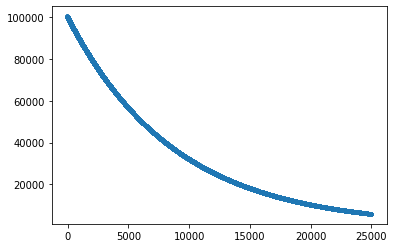

In [79]:
''' Set hydrostatic pressure from isothermal air atmosphere '''
# chamber_y_top =  -1700

hydrostatic_atm = lambda x: 1e5 * np.exp(-x / scale_height)
p0_extrapolated = hydrostatic_atm(x[..., 1:2])

# chamber_top_hydrostatic = hydrostatic_linear(chamber_y_top)

# hydrostatic_twopart = lambda x: np.where(x >= chamber_y_top,
#                                   np.where(x < surf_height,
#                                     -1000 * 9.8 * (x - surf_height) + 1e5,
#                                     1e5),
#                                   -2600 * 9.8 * (x - chamber_y_top)+ chamber_top_hydrostatic)
# p0_extrapolated = hydrostatic_twopart(x[..., 1:2])
plt.plot(x[..., 1:2].ravel(), p0_extrapolated.ravel(), '.')


### Generate conduit

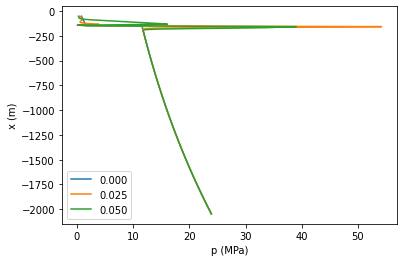

In [33]:
conduit_i = lambda i: f"ringfault_above_ocean_conduit_{i}.pkl"
conduit_from = lambda i: readwritedatafiles.read_data_file(conduit_i(i))

_solver = conduit_from(0)
_t0 = _solver.time
p = _solver.physics.compute_variable("Pressure", _solver.state_coeffs)
plt.plot(p.ravel() / 1e6, _solver.elem_helpers.x_elems.ravel())
plt.xlabel("p (MPa)")
plt.ylabel("x (m)")

_solver = conduit_from(1)
_t1 = _solver.time
p = _solver.physics.compute_variable("Pressure", _solver.state_coeffs)
plt.plot(p.ravel() / 1e6, _solver.elem_helpers.x_elems.ravel())
plt.xlabel("p (MPa)")
plt.ylabel("x (m)")

_solver = conduit_from(2)
_t2 = _solver.time
p = _solver.physics.compute_variable("Pressure", _solver.state_coeffs)
plt.plot(p.ravel() / 1e6, _solver.elem_helpers.x_elems.ravel())
plt.xlabel("p (MPa)")
plt.ylabel("x (m)")

_solver.elem_helpers.x_elems.shape, p.ravel().shape
plt.legend([f"{_t0:.3f}", f"{_t1:.3f}", f"{_t2:.3f}"])

In [ ]:
_solver.state_coeffs[...,1:2].shap

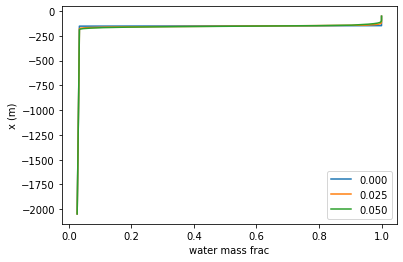

In [37]:
conduit_i = lambda i: f"ringfault_above_ocean_conduit_{i}.pkl"
conduit_from = lambda i: readwritedatafiles.read_data_file(conduit_i(i))

_solver = conduit_from(0)
_t0 = _solver.time
yw = _solver.state_coeffs[...,1] / _solver.state_coeffs[...,0:3].sum(axis=-1)
plt.plot(yw.ravel(), _solver.elem_helpers.x_elems.ravel())

_solver = conduit_from(1)
_t1 = _solver.time
yw = _solver.state_coeffs[...,1] / _solver.state_coeffs[...,0:3].sum(axis=-1)
plt.plot(yw.ravel(), _solver.elem_helpers.x_elems.ravel())

_solver = conduit_from(2)
_t2 = _solver.time
yw = _solver.state_coeffs[...,1] / _solver.state_coeffs[...,0:3].sum(axis=-1)
plt.plot(yw.ravel(), _solver.elem_helpers.x_elems.ravel())
plt.xlabel("water mass frac")
plt.ylabel("x (m)")

_solver.elem_helpers.x_elems.shape, yw.ravel().shape
plt.legend([f"{_t0:.3f}", f"{_t1:.3f}", f"{_t2:.3f}"])

### Generate plots

In [16]:
surf_height = 150
  
def format_plot(clims:tuple, soln_vars_i:object, cbar_label:str):
  # Make and format colorbar
  sm = plt.cm.ScalarMappable(
    norm=matplotlib.colors.Normalize(vmin=clims[0], vmax=clims[1]),
    cmap=plt.get_cmap())
  cb = plt.colorbar(sm)
  cb.set_label(label=cbar_label, fontsize=15)
  cb.ax.tick_params(labelsize=13)
  # Format (x,y) ticks
  plt.xticks(fontsize=13)
  plt.yticks(fontsize=13)
  ax = plt.gca()
  # ax.yaxis.set_major_formatter(lambda x, _: f"{surf_height-x}")
  # Make title
  tl = plt.title(f"t = {1e3*soln_vars_i.t:.2f} ms")
  # Set view window
  plt.xlim(0, 25000)
  plt.ylim(0, 15625)
  # plt.xlim(0, 3200)
  # plt.ylim(0, 2000)
  # Label x, y axes
  xlabel = plt.xlabel("Radial distance (m)", fontsize=15)
  ylabel = plt.ylabel("Altitude (m a.s.l.)", fontsize=15)
  # ylabel = plt.ylabel("Water depth (m)", fontsize=15)

  # plt.xticks(ticks=np.unique([*plt.xticks()[0], 1150, 1300]))

  # Add details for inflow limits
  plt.plot([1150, 1150], [0, 300], '--w')
  plt.plot([1300, 1300], [0, 300], '--w')

  return cb, ax, tl, xlabel, ylabel, sm

C:\Users\Fredric\AppData\Local\Temp\ipykernel_3860\1551933555.py:72: RuntimeWarning: divide by zero encountered in double_scalars
  (1.0/rhow - 1.0/sat_tup[1]) / (1.0/sat_tup[2] - 1.0/sat_tup[1]), 0, 1.0


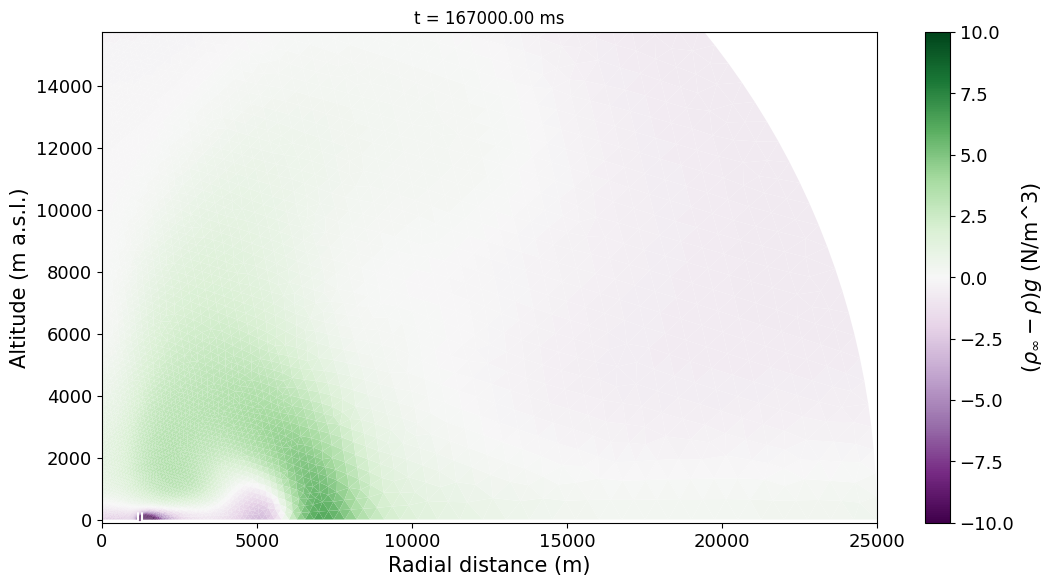

In [80]:
%matplotlib inline

num_plots = 1
file_radix = "entrainment4_extended"
descriptor = "_test" # "_temp"
figs = [plt.figure(figsize=(12.5,6.5), dpi=100) for i in range(num_plots)]

for i in np.arange(0,2001,100): # np.arange(0,1176,25 # 90 s
  soln_vars_i = process_file(i, [0], solver_from_multi, x=x_precomputed)
  vel_norm = np.sqrt(soln_vars_i.u * soln_vars_i.u + soln_vars_i.v * soln_vars_i.v)
  M = vel_norm / soln_vars_i.c
  
  # Pressure difference from starting (approximate) hydrostatic
  figs[0].clf()
  plt.figure(figs[0])
  # clims = (-0.5, 1)
  # plt.set_cmap("viridis")
  # mdtools.plot_mean(x, (soln_vars_i.p - p0_extrapolated)/1e5, clims)
  # format_plot(clims, soln_vars_i, 'Excess pressure (bar)')
  # plt.savefig(f"{file_radix}_pressure{descriptor}_frame_{i}.png", format="png")

  # figs[1].clf()
  # plt.figure(figs[1])
  # clims = (0, 200)
  # plt.set_cmap("plasma")
  # mdtools.plot_mean(x, vel_norm, clims)
  # format_plot(clims, soln_vars_i, 'Velocity (m/s)')
  # plt.savefig(f"{file_radix}_velocitynorm{descriptor}_frame_{i}.png", format="png")

  # figs[2].clf()
  # plt.figure(figs[2])
  # clims = (-100., 100)
  # plt.set_cmap("PiYG")
  # mdtools.plot_mean(x, soln_vars_i.v, clims)
  # format_plot(clims, soln_vars_i, 'Vertical velocity (m/s)')
  # plt.savefig(f"{file_radix}_vvelocity{descriptor}_frame_{i}.png", format="png")

  # figs[3].clf()
  # plt.figure(figs[3])
  # clims = (-0.5, 2.0)
  # plt.set_cmap("plasma")
  # mdtools.plot_mean(x, np.log10(soln_vars_i.rho_mix), clims)
  # format_plot(clims, soln_vars_i, 'log10 (density (kg/m${}^3$) )')
  # plt.savefig(f"{file_radix}_log10density{descriptor}_frame_{i}.png", format="png")

  # figs[4].clf()
  # plt.figure(figs[4])
  # clims = (-2., 0)
  # plt.set_cmap("plasma")
  # mdtools.plot_mean(x, np.log10(M), clims)
  # format_plot(clims, soln_vars_i, 'log10(|M|)')
  # plt.savefig(f"{file_radix}_log10machnorm{descriptor}_frame_{i}.png", format="png")

  # figs[5].clf()
  # plt.figure(figs[5])
  # clims = (275, 1400)
  # plt.set_cmap("coolwarm")
  # mdtools.plot_mean(x, soln_vars_i.T, clims)
  # format_plot(clims, soln_vars_i, 'Temperature (K)')
  # plt.savefig(f"{file_radix}_temperature{descriptor}_frame_{i}.png", format="png")

  # figs[6].clf()
  # plt.figure(figs[6])
  # clims = (-4, 0)
  # plt.set_cmap("seismic_r")
  # mdtools.plot_mean(x, np.log10(soln_vars_i.yw), clims)
  # format_plot(clims, soln_vars_i, 'log10(water mass frac)')
  # plt.savefig(f"{file_radix}_log10yw{descriptor}_frame_{i}.png", format="png")

  # figs[7].clf()
  # plt.figure(figs[7])
  # clims = (-1, 1)
  # plt.set_cmap("gist_heat")
  # mdtools.plot_mean(x, soln_vars_i.steamfrac, clims)
  # format_plot(clims, soln_vars_i, 'Steam fraction')
  # plt.savefig(f"{file_radix}_steamfrac{descriptor}_frame_{i}.png", format="png")

  # figs[8].clf()
  # plt.figure(figs[8])
  # clims = (-100., 100)
  # plt.set_cmap("BrBG")
  # mdtools.plot_mean(x, soln_vars_i.u, clims)
  # format_plot(clims, soln_vars_i, 'Horizontal velocity (m/s)')
  # plt.savefig(f"{file_radix}_uvelocity{descriptor}_frame_{i}.png", format="png")

  # arhoW = soln_vars_i.rho_mix * soln_vars_i.yw
  # arhoM = soln_vars_i.rho_mix * soln_vars_i.ym
  # r_mean = x.mean(axis=1, keepdims=True)[...,0:1]

  # figs[9].clf()
  # plt.figure(figs[9])
  # clims = (0., 2500)
  # plt.set_cmap("Blues")
  # mdtools.plot_mean(x, 2*np.pi*r_mean*arhoW, clims)
  # format_plot(clims, soln_vars_i, 'Water partial area density (kg/m^2)')
  # plt.savefig(f"{file_radix}_rarhoW{descriptor}_frame_{i}.png", format="png")

  # figs[10].clf()
  # plt.figure(figs[10])
  # clims = (0., 10000)
  # plt.set_cmap("copper")
  # mdtools.plot_mean(x, 2*np.pi*r_mean*arhoM, clims)
  # format_plot(clims, soln_vars_i, 'Magma partial area density (kg/m^2)')
  # plt.savefig(f"{file_radix}_rarhoM{descriptor}_frame_{i}.png", format="png")

  rho_inf = 1e5 / (287 * 300) * np.exp(-x[..., 1:2] / scale_height)
  
  # figs[11].clf()
  # plt.figure(figs[11])
  clims = (-1e1, 1e1)
  plt.set_cmap("PRGn")
  mdtools.plot_mean(x, (rho_inf - soln_vars_i.rho_mix)*9.8, clims)
  format_plot(clims, soln_vars_i, '$(\\rho_\\infty - \\rho) g$ (N/m^3)')
  plt.savefig(f"{file_radix}_buoyancy{descriptor}_frame_{i}.png", format="png")

C:\Users\Fredric\AppData\Local\Temp\ipykernel_3860\1551933555.py:72: RuntimeWarning: divide by zero encountered in double_scalars
  (1.0/rhow - 1.0/sat_tup[1]) / (1.0/sat_tup[2] - 1.0/sat_tup[1]), 0, 1.0


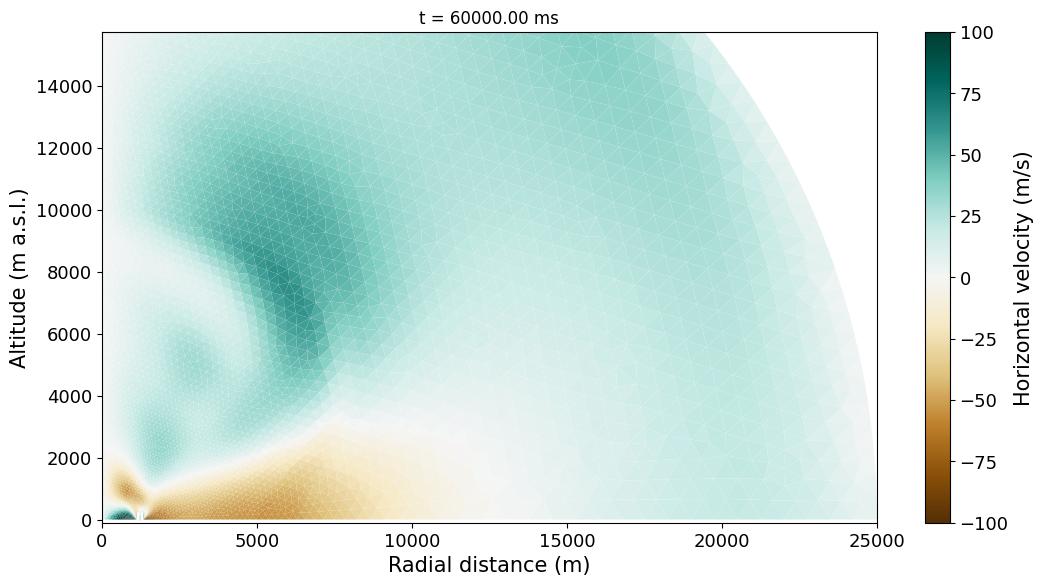

In [20]:
''' New plots: horizontal velocity '''
num_plots = 1
file_radix = "entrainment4"
descriptor = "" # "_temp"
figs = [plt.figure(figsize=(12.5,6.5), dpi=100) for i in range(num_plots)]

for i in np.arange(0,1001,50): # 90 s
  soln_vars_i = process_file(i, [0], solver_from_multi, x=x_precomputed)
  vel_norm = np.sqrt(soln_vars_i.u * soln_vars_i.u + soln_vars_i.v * soln_vars_i.v)
  M = vel_norm / soln_vars_i.c

  figs[0].clf()
  plt.figure(figs[0])
  clims = (-100., 100)
  plt.set_cmap("BrBG")
  mdtools.plot_mean(x, soln_vars_i.u, clims)
  format_plot(clims, soln_vars_i, 'Horizontal velocity (m/s)')
  plt.savefig(f"{file_radix}_uvelocity{descriptor}_frame_{i}.png", format="png")

In [41]:
x.mean(axis=1, keepdims=True)[...,0:1]

((9525, 3, 2), (9525, 1, 1), (9525, 3, 2))

C:\Users\Fredric\AppData\Local\Temp\ipykernel_3860\1551933555.py:72: RuntimeWarning: divide by zero encountered in double_scalars
  (1.0/rhow - 1.0/sat_tup[1]) / (1.0/sat_tup[2] - 1.0/sat_tup[1]), 0, 1.0


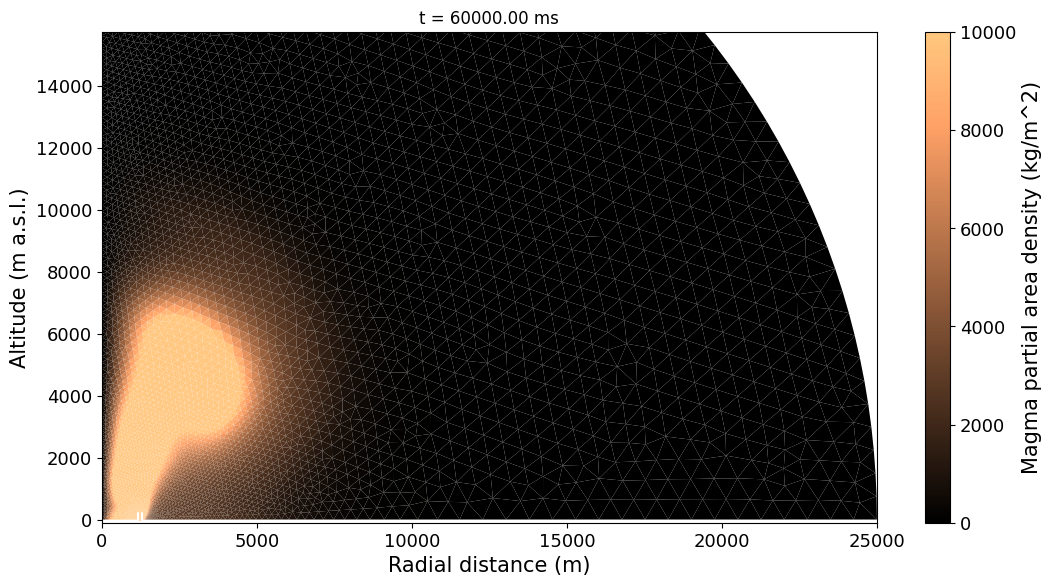

In [53]:
''' New plots: r * magma mass '''
num_plots = 1
file_radix = "entrainment4"
descriptor = "" # "_temp"
figs = [plt.figure(figsize=(12.5,6.5), dpi=100) for i in range(num_plots)]

for i in np.arange(0,1001,50): # 90 s wall per image @ 8 fields
  soln_vars_i = process_file(i, [0], solver_from_multi, x=x_precomputed)
  arhoW = soln_vars_i.rho_mix * soln_vars_i.yw
  arhoM = soln_vars_i.rho_mix * soln_vars_i.ym
  r_mean = x.mean(axis=1, keepdims=True)[...,0:1]

  figs[0].clf()
  plt.figure(figs[0])
  # clims = (0., 2500)
  # plt.set_cmap("Blues")
  # mdtools.plot_mean(x, 2*np.pi*r_mean*arhoW, clims)
  # format_plot(clims, soln_vars_i, 'Water partial area density (kg/m^2)')
  # plt.savefig(f"{file_radix}_rarhoW{descriptor}_frame_{i}.png", format="png")

  # figs[1].clf()
  # plt.figure(figs[1])
  clims = (0., 10000)
  plt.set_cmap("copper")
  mdtools.plot_mean(x, 2*np.pi*r_mean*arhoM, clims)
  format_plot(clims, soln_vars_i, 'Magma partial area density (kg/m^2)')
  plt.savefig(f"{file_radix}_rarhoM{descriptor}_frame_{i}.png", format="png")

C:\Users\Fredric\AppData\Local\Temp\ipykernel_3860\1551933555.py:72: RuntimeWarning: divide by zero encountered in double_scalars
  (1.0/rhow - 1.0/sat_tup[1]) / (1.0/sat_tup[2] - 1.0/sat_tup[1]), 0, 1.0


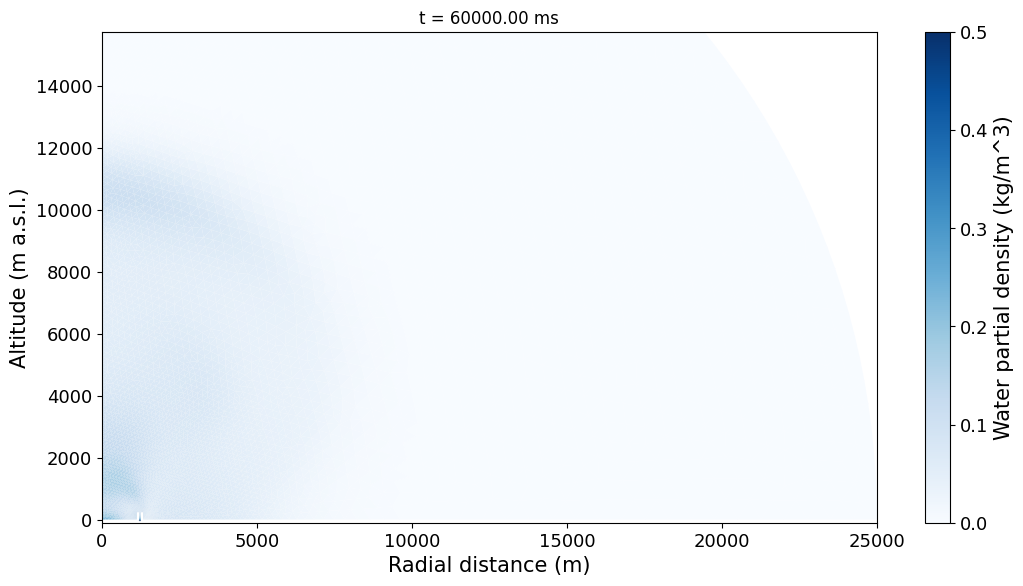

In [35]:
''' New plots: magma/water mass '''
num_plots = 1
file_radix = "entrainment4"
descriptor = "" # "_temp"
figs = [plt.figure(figsize=(12.5,6.5), dpi=100) for i in range(num_plots)]

for i in np.arange(0,1001,50): # 90 s wall per image @ 8 fields
  soln_vars_i = process_file(i, [0], solver_from_multi, x=x_precomputed)
  arhoW = soln_vars_i.rho_mix * soln_vars_i.yw
  arhoM = soln_vars_i.rho_mix * soln_vars_i.ym

  figs[0].clf()
  plt.figure(figs[0])
  clims = (0., 0.5)
  plt.set_cmap("Blues")
  mdtools.plot_mean(x, arhoW, clims)
  format_plot(clims, soln_vars_i, 'Water partial density (kg/m^3)')
  plt.savefig(f"{file_radix}_arhoW{descriptor}_frame_{i}.png", format="png")

  # figs[1].clf()
  # plt.figure(figs[1])
  # clims = (0., 5)
  # plt.set_cmap("copper")
  # mdtools.plot_mean(x, arhoM, clims)
  # format_plot(clims, soln_vars_i, 'Magma partial density (kg/m^3)')
  # plt.savefig(f"{file_radix}_arhoM{descriptor}_frame_{i}.png", format="png")

C:\Users\Fredric\AppData\Local\Temp\ipykernel_3860\1551933555.py:72: RuntimeWarning: divide by zero encountered in double_scalars
  (1.0/rhow - 1.0/sat_tup[1]) / (1.0/sat_tup[2] - 1.0/sat_tup[1]), 0, 1.0


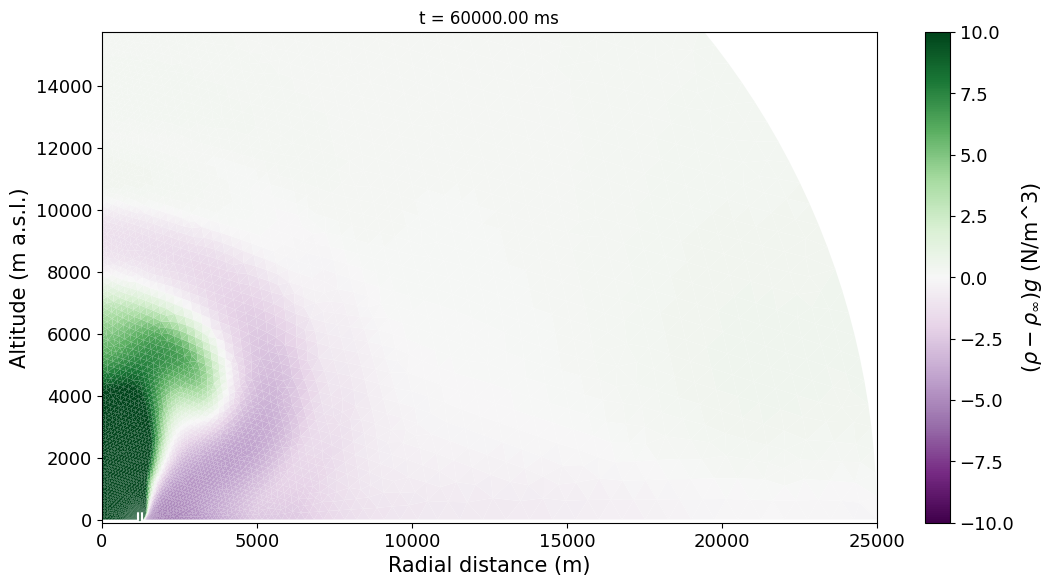

In [67]:
''' New plots: relative weight '''
num_plots = 1
file_radix = "entrainment4"
descriptor = "" # "_temp"
figs = [plt.figure(figsize=(12.5,6.5), dpi=100) for i in range(num_plots)]

hydrostatic_air_density = lambda x: 1e5 / (287 * 300) * np.exp(-x / scale_height)

for i in np.arange(0,1001,50): # 90 s wall per image @ 8 fields
  soln_vars_i = process_file(i, [0], solver_from_multi, x=x_precomputed)
  rho_mix = soln_vars_i.rho_mix
  rho_inf = hydrostatic_air_density(x[..., 1:2])
  
  figs[0].clf()
  plt.figure(figs[0])
  clims = (-1e1, 1e1)
  plt.set_cmap("PRGn")
  mdtools.plot_mean(x, (rho_mix - rho_inf)*9.8, clims)
  format_plot(clims, soln_vars_i, '$(\\rho - \\rho_\\infty) g$ (N/m^3)')
  plt.savefig(f"{file_radix}_buoyancy{descriptor}_frame_{i}.png", format="png")

In [ ]:
''' Velocity polar '''
fig = plt.figure(figsize=(14.5,6.0), dpi=100)
plt.set_cmap("hsv")

filter_min_vel = 0.2

grid_spec = matplotlib.gridspec.GridSpec(1, 3)
ax1 = fig.add_subplot(grid_spec[0,0:2])
ax2 = fig.add_subplot(grid_spec[0,2], projection='polar')

clims = (-np.pi, np.pi)
for i in np.arange(0,501,1):
  plt.cla()
  plt.sca(ax1)

  soln_vars_i = process_file(i, [0], solver_from_multi)
  vel_norm = np.sqrt(soln_vars_i.u * soln_vars_i.u + soln_vars_i.v * soln_vars_i.v)
  vel_angle = np.arctan2(soln_vars_i.v, soln_vars_i.u)
  vel_angle = np.where(vel_norm > filter_min_vel, vel_angle, np.nan)

  mdtools.plot_mean(x, vel_angle, clims)
  # sm = plt.cm.ScalarMappable(
  #   norm=matplotlib.colors.Normalize(vmin=clims[0], vmax=clims[1]),
  #   cmap=plt.get_cmap())
  tl = plt.title(f"t = {1e3*soln_vars_i.t:.2f} ms")

  plt.xlim(0, 5700)
  plt.ylim(-3300, surf_height)
  plt.xticks(fontsize=13)
  plt.yticks(fontsize=13)

  plt.xlabel("Radial distance (m)", fontsize=15)
  ax = plt.gca()
  ax.yaxis.set_major_formatter(lambda x, _: f"{surf_height-x}")
  plt.ylabel("Water depth (m)", fontsize=15)
  
  ax = ax2
  _r = np.linspace(0.9,1,2)
  _theta = np.linspace(-np.pi, np.pi, 200)
  im = ax.pcolormesh(
    _theta,
    _r,
    np.meshgrid(_r, _theta, indexing="ij")[1],
    norm=matplotlib.colors.Normalize(_theta[0], _theta[-1]),
    shading="auto",
  )
  ax.spines['polar'].set_visible(False)
  ax.set_yticklabels([])

  out_file_name = f"ringfault9_velocityangle_frame_{i}.png"
  plt.savefig(out_file_name, format="png")

----------------

In [120]:
# Bug hunting
i_latest = 247
soln_vars_latest = process_file(i_latest, [0], solver_from_multi)
solver_latest = solver_from(i_latest)
soln_vars_penult = process_file(i_latest-1, [0], solver_from_multi)
solver_penult = solver_from(i_latest-1)
soln_vars_baseline = process_file(100, [0], solver_from_multi)
solver_baseline = solver_from(100)

C:\Users\Fredric\AppData\Local\Temp\ipykernel_192276\1551933555.py:72: RuntimeWarning: divide by zero encountered in double_scalars
  (1.0/rhow - 1.0/sat_tup[1]) / (1.0/sat_tup[2] - 1.0/sat_tup[1]), 0, 1.0


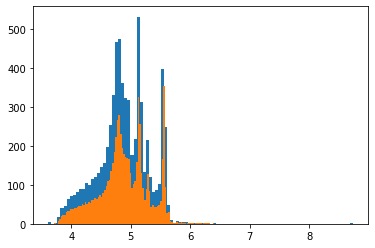

In [113]:
hist = plt.hist(np.log10(soln_vars_latest.p.ravel()), bins=100)
hist = plt.hist(np.log10(soln_vars_penult.p.ravel()), bins=100)

In [125]:
np.maximum((3,4),5)

array([5, 5])

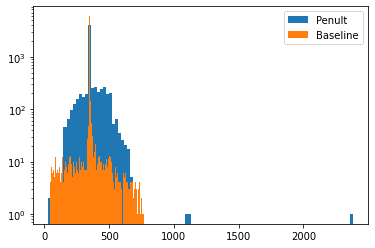

In [121]:
w = np.abs(soln_vars_penult.u) + soln_vars_penult.c
hist = plt.hist((w.ravel()), bins=100)
w = np.abs(soln_vars_baseline.u) + soln_vars_baseline.c
hist = plt.hist((w.ravel()), bins=100)
plt.yscale("log")
plt.legend(["Penult", "Baseline"])

In [143]:
# _i = np.argmin(_p)
_i

'_i = np.argmin(_p)\n_i'

In [141]:
_U[_i:_i+1,:]

TypeError: can only concatenate str (not "int") to str

In [151]:
solver.physics.compute_variable("Pressure", 
np.array([ 7.500164991394116e-01,  1e3*8.724007993919471e-07,
         1e3*2.307363237378165e-07, -1.246345716725480e-03,
         1.212279025280211e+00,  1.628530801516563e+05,
         8.761769234080738e-07,  2.317605974766907e-14,
         7.500238518240132e-09])[np.newaxis, np.newaxis,:])

array([[[61426.17738755762]]])

In [154]:
_p = soln_vars_latest.p.ravel()
i = np.argmax(_p)
_U = solver_latest.state_coeffs.squeeze(axis=1)
_Ulast = solver_penult.state_coeffs.squeeze(axis=1)

_Ulast[i,:], _U[i,:], soln_vars_penult.p.ravel()[i], soln_vars_latest.p.ravel()[i]


(array([1.349825559629250e+00, 9.232729373032782e-03,
        2.306390109123807e-03, 9.350285557358549e+01,
        2.894698930063288e+02, 4.234347782937040e+05,
        9.271739641281964e-03, 2.386702948825815e-10,
        1.427797959239830e-08]),
 array([-7.389101065163146e-01, -9.860041025926726e-02,
        -2.476545035710549e-02, -1.939039988258314e+03,
        -6.994374443693318e+03, -2.155891008036250e+06,
        -9.901931518378933e-02, -2.562793751979320e-09,
        -1.573393771376642e-08]),
 149798.42999427795,
 533289605.1610059)

In [158]:
_Ulast[i,0:3] / _Ulast[i,0:3].sum(axis=-1,keepdims=True), \
_U[i,0:3] / _U[i,0:3].sum(axis=-1,keepdims=True)


(array([0.991523858625678, 0.006781966298009, 0.001694175076313]),
 array([0.856929955932091, 0.114349018200219, 0.02872102586769 ]))

In [165]:
# Reference energy of water?
mixtureWLMA.float_mix_functions.u(mixtureWLMA.float_mix_functions.rho_l_pt(1e5, 300), 300), \
mixtureWLMA.float_mix_functions.u(mixtureWLMA.float_mix_functions.rho_l_pt(1e5, 1000), 1000), \
mixtureWLMA.float_mix_functions.u(mixtureWLMA.float_mix_functions.rho_l_pt(1e4, 300), 300), \
  287 * 300

(112553.33413263572, 3529258.8483349914, 112560.77617429612, 86100)

------------

In [ ]:
''' Copying code for examining along a line '''

''' Copying spherical surface (circular arc) '''
class ControlSurface():
  def __init__(self, R, N, x0=0, y0=0, thetamin=0):
    self.R = R
    self.N = N
    # Compute area of quarter-sphere
    self.A = np.pi * self.R * self.R
    # Evenly space nodes at circle center
    self.theta = np.linspace(thetamin, 0.5*np.pi, 2*self.N+1)[1::2]
    self.dtheta = 0.5*np.pi / self.N
    # Compute Cartesian coordinates of sample points
    self.x = x0 + self.R * np.cos(self.theta)
    self.y = y0 + self.R * np.sin(self.theta)
    # Alias x coordinate as r (in cylindrical coordinates)
    self.r = self.x
    # Jacobian for quarter sphere is pi * R**2 sin(pi/2 - theta), where theta is the
    #   angle from the HORIZONTAL axis. jac_theta is the jacobian for integration
    #   against in-plane angle theta from the horizontal axis.
    self.jac_theta = np.pi * self.R * self.r
    # Define integration functional, contracting f_xy(r, y) along the first dimension
    # self.integrate = lambda f_xy: np.sum(
    #   f_xy(self.r, self.y)
    #   * (self.jac_theta * self.dtheta)[:,np.newaxis],
    #   # axis=(0,)
    #   axis=(0,1)
    # )
    self.integrate = lambda f_xy: np.einsum("j..., j -> ...",
      f_xy(self.r, self.y),
      self.jac_theta * self.dtheta,
    )

dt_file = solver_from_multi(0,1).time - solver_from_multi(0,0).time
physics = solver_from_multi(0,0).physics

def xyt_interpolator_P0(x, y, t:np.array):
  ''' xyt interpolator implementation for element order 0.
  Input shapes:
    x: (n,)
    y: (n,)
    t: (m,)
  Output:
    U(x,y,t): (n,m,9)'''
  file_indices, thetas = divmod(t, dt_file)
  # Find relevant element indices
  elem_indices = mdtools.SolverInterpolator(solver_from(0)).trifinder(x, y)

  NUM_STATES = 9
  U_out = np.zeros((x.size,  t.size, NUM_STATES))

  for i, _ in enumerate(file_indices):
    # Find file indices
    theta = thetas[i]
    file_idx0 = int(file_indices[i])

    solver = solver_from(file_idx0)
    if solver.order > 0:
      raise ValueError("Element order is not 0, but using P0 interpolator")
    U0 = solver.state_coeffs[elem_indices, 0, :]

    if theta > 0:
      solver = solver_from(file_idx0+1)
    U1 =  solver.state_coeffs[elem_indices, 0, :]

    # Linearly interpolate state between file i and i+1
    U_out[:,i,:] = (1.0 - thetas[i]) * U0 + thetas[i] * U1
  return U_out

# xyt_interpolator_P0(control_surface.x, control_surface.y, np.array([0.2]))
xyt = xyt_interpolator_P0

def surface_integral(control_surface, t_array:np.array, dependent_fn:str):
  ''' Returns 3D surface integral of quant_name (e.g. Pressure) at time points
    as 1-D array t_array. '''
  # Pass dependent variable map composed with interpolator to control
  # surface functional
  return control_surface.integrate(
    lambda x, y: dependent_fn(xyt(x, y, t_array), x, y))

# Map from state coefficients to pressure
def U2p(U, x, y):
  return physics.compute_variable("Pressure", U)

def work_rate(U, x, y):
  ''' Return p * u (work per area-second)'''
  rho = U[...,0:3].sum(axis=-1, keepdims=True)
  r = np.sqrt(x*x + y*y)
  # Scalar component of normal velocity
  vel_normal = (np.einsum("ijk, i -> ijk", U[...,3:4], x/r)
                + np.einsum("ijk, i -> ijk ", U[...,4:5], y/r)) / rho
  return physics.compute_variable("Pressure", U) * vel_normal

def kinetic_flux(U, x, y):
  ''' Return 0.5 * rho * ||u||^2 * u_n (kinetic energy per area-second) '''
  rho = U[...,0:3].sum(axis=-1, keepdims=True)
  r = np.sqrt(x*x + y*y)
  # Scalar component of normal velocity
  vel_normal = (np.einsum("ijk, i -> ijk", U[...,3:4], x/r)
                + np.einsum("ijk, i -> ijk ", U[...,4:5], y/r)) / rho
  return 0.5 * (U[...,3:5]*U[...,3:5]).sum(axis=-1, keepdims=True) / rho * vel_normal

def mass_rate(U, x, y):
  ''' Return rho * vel_normal '''
  rho = U[...,0:3].sum(axis=-1, keepdims=True)
  r = np.sqrt(x*x + y*y)
  # Scalar component of normal velocity
  vel_normal = (np.einsum("ijk, i -> ijk", U[...,3:4], x/r)
                + np.einsum("ijk, i -> ijk ", U[...,4:5], y/r)) / rho
  return rho * vel_normal

def vol_rate(U, x, y):
  ''' Return vel_normal '''
  rho = U[...,0:3].sum(axis=-1, keepdims=True)
  r = np.sqrt(x*x + y*y)
  # Scalar component of normal velocity
  vel_normal = (np.einsum("ijk, i -> ijk", U[...,3:4], x/r)
                + np.einsum("ijk, i -> ijk ", U[...,4:5], y/r)) / rho
  return vel_normal

# Test integration
# R = 500

integrated_p = surface_integral(ControlSurface(49.5, 30, y0=-100, thetamin=-np.pi/2), np.array([0.70000]), U2p)
# integrated_work = surface_integral(ControlSurface(R, 20), np.array([0.70000]), work_rate)
# integrated_kinetic = surface_integral(ControlSurface(R, 20), np.array([0.70000]), kinetic_flux)
# integrated_massrate = surface_integral(ControlSurface(R, 20), np.array([0.70000]), mass_rate)
# integrated_volrate = surface_integral(ControlSurface(R, 20), np.array([0.70000]), vol_rate)
integrated_p

In [ ]:
# Pinpoint location
t_loc = np.arange(0, 12.6, 2*dt_file)
U_loc = xyt(np.array([5000]), np.array([150]), t_loc)

In [ ]:
file_name_i(0)

In [ ]:
p_loc = solver.physics.compute_variable("Pressure",
                                        np.reshape(U_loc, (-1, 1, 9))) # Move size to element-index rather than basis-index
sensor_depth = 150
t_wavetravel = 5000/1500
p_hydrostatic_at_height = 9.8 * sensor_depth * 998
distance_factor = 5/4740 # 4740 km for HA11 (see Le Bras et al. 2023 , SRL)
plt.title("Pressure 5 km from the source, 150 m depth")
plt.plot(t_loc-t_wavetravel, 1*(p_loc - p_hydrostatic_at_height).ravel()/1e3, '.-')
plt.xlabel("t - r/c_0 (s)")
plt.ylabel("p (kPa)")
plt.xlim(left=-2)

In [ ]:
# Set chamber ellipsoidal geometry
chamber_y_center = -2500
chamber_horizontal_semiaxis = 2000

In [ ]:
# Evaluate pressure in chamber using chamber mean (why is ControlSurface buggy?)
p_chamber_mean_record = []
t_record = []
for i in range(352): # full range: #range(500):
  _solver = solver_from_multi(0,i)
  # Simple pressure estimation
  # _U_chamber = _solver.state_coeffs[_solver.elem_helpers.x_elems[:,0,1] <= -100,...]
  # _p_chamber = _solver.physics.compute_variable("Pressure",_U_chamber)
  # p_chamber_mean_record.append(_p_chamber.mean())

  # Associate angle, pressure with each face_x
  bgroup_num = _solver.mesh.boundary_groups["chamberwallouter"].number
  face_length = _solver.bface_helpers.face_lengths_bgroups[bgroup_num]
  face_x = _solver.bface_helpers.x_bgroups[bgroup_num]
  elem_IDs = _solver.bface_helpers.elem_IDs[bgroup_num]
  x_boundary = _solver.elem_helpers.x_elems[elem_IDs,...]
  face_p = _solver.physics.compute_variable("Pressure",
    _solver.state_coeffs[elem_IDs,...])
  # Compute position relative to ellipsoidal chamber center
  face_rel_x = face_x - np.array([0, -chamber_y_center])
  # Rotated position vector
  pos = np.einsum("ij, ...j -> ...i", np.array([[0, -1], [1, 0]]), face_rel_x)
  # Compute phi for points on face
  face_phi = np.arctan2(pos[:,0,1], pos[:,0,0])
  # Jac 2 * pi * cos(phi) * r * ds
  face_jac = 2 * np.pi * np.cos(face_phi) * face_x[:,0,0] * face_length[:,0]
  # Integration weights
  face_weights = np.where(face_phi <= np.pi/2, face_jac, 0)
  # Pressure integration
  p_chamber_mean_record.append(np.dot(face_p.ravel(), face_weights))

  t_record.append(_solver.time)

In [ ]:
_solver.physics.compute_variable("Pressure",
    _solver.state_coeffs[elem_IDs,...]).max() * 2000**2 * np.pi/1e13

In [ ]:
# Compute geometry on chamberwallouter boundary
bgroup_num = solver.mesh.boundary_groups["chamberwallouter"].number
face_length = solver.bface_helpers.face_lengths_bgroups[bgroup_num]
face_x = solver.bface_helpers.x_bgroups[bgroup_num]
elem_IDs = solver.bface_helpers.elem_IDs[bgroup_num]
x_boundary = _solver.elem_helpers.x_elems[elem_IDs,...]

# Association check
_check_association = False
if _check_association:
  for i in range(elem_IDs.size):
    # Associate face_x with point in elem
    plt.plot(
      [face_x[i,0,0], *x_boundary[i,:,0]], # Solo point in face_x[elem_ID] and all x_elem[elem_ID] points
      [face_x[i,0,1], *x_boundary[i,:,1]],
      '.-'
    )
  # plt.scatter(x_boundary[...,0].ravel(), x_boundary[...,1].ravel())
    
  # plt.scatter(face_x[...,0], face_x[...,1])# face_length
  # _x_lowerchamber = _solver.elem_helpers.x_elems[_solver.elem_helpers.x_elems[:,0,1] <= -100,...]
  # _U_lowerchamber = _solver.state_coeffs[_solver.elem_helpers.x_elems[:,0,1] <= -100,...]
  # plt.scatter(_x_lowerchamber[1,:,0], _x_lowerchamber[1,:,1])
    
_one_step_check = False
if _one_step_check:
  # Associate angle, pressure with each face_x
  face_x.shape, elem_IDs.shape
  face_p = solver.physics.compute_variable("Pressure",
    solver.state_coeffs[elem_IDs,...])
  # Compute position relative to ellipsoidal chamber center
  face_rel_x = face_x - np.array([0, chamber_y_center])
  # Rotated position vector
  pos = np.einsum("ij, ...j -> ...i", np.array([[0, -1], [1, 0]]), face_rel_x)
  # Compute phi for points on face
  face_phi = np.arctan2(pos[:,0,1], pos[:,0,0])
  # Jac
  face_jac = 2 * np.pi * np.cos(face_phi) * face_x[:,0,0] * face_length[:,0]
  # Integration weights
  face_weights = np.where(face_phi <= np.pi/2, face_jac, 0)
  # Area check
  face_weights.sum(), np.pi * chamber_horizontal_semiaxis ** 2
  # Pressure integration
  np.dot(face_p.ravel(), face_weights)

In [ ]:
# t_mw = np.array(t_record).copy()
# p_mw = np.array(p_chamber_mean_record).copy()

In [ ]:
plt.figure(figsize=(7.5, 5))
plt.plot(np.array(t_record), np.array(p_chamber_mean_record) / 1e13)
plt.xticks(fontsize=13)
plt.yticks(fontsize=13)
plt.xlabel("Time (s)", fontsize=15)
plt.ylabel("Force (${10}^{13}$ N)", fontsize=15)

ax = plt.gca()

In [ ]:
t_ma = np.array(t_record).copy()
p_ma = np.array(p_chamber_mean_record).copy()

In [ ]:
# np.savez("pressure_newton-second_magmaair-magmawater", t_ma=t_ma, p_ma=p_ma, t_mw=t_mw, p_mw=p_mw)

In [ ]:
plt.figure(figsize=(7.5, 5))
plt.plot(np.array(t_record), np.array(p_chamber_mean_record) / 1e13)
plt.xticks(fontsize=13)
plt.yticks(fontsize=13)
plt.xlabel("Time (s)", fontsize=15)
plt.ylabel("Force (${10}^{13}$ N)", fontsize=15)

ax = plt.gca()

In [ ]:
plt.figure(figsize=(7.5, 5), dpi=100)
plt.plot(t_ma, p_ma / 1e13)
plt.plot(t_mw, p_mw / 1e13)
plt.xticks(fontsize=13)
plt.yticks(fontsize=13)
plt.xlabel("Time (s)", fontsize=15)
plt.ylabel("Force (${10}^{13}$ N)", fontsize=15)
plt.legend(["Magma-air 10 MPa overpressure", "Magma-water"])

### Line analysis

In [ ]:
# Find points in ring fault
# (solver.mesh.boundary_groups["dikeouter"].boundary_faces[0].face_ID)

# Boundary faces of boundary "dikeouter"
outer_bfaces = solver.mesh.boundary_groups["dikeouter"].boundary_faces
inner_bfaces = solver.mesh.boundary_groups["dikeinner"].boundary_faces
# Identify nodes attached to elements on the outer boundary
outer_bface_nodes = np.array([solver.mesh.elements[bface.elem_ID].node_coords for bface in outer_bfaces])
inner_bface_nodes = np.array([solver.mesh.elements[bface.elem_ID].node_coords for bface in inner_bfaces])

# Find minimum y-coordinate within each set of nodes
outer_bface_nodes = np.reshape(outer_bface_nodes, (-1, 2))
inner_bface_nodes = np.reshape(inner_bface_nodes, (-1, 2))
lowest_outer_node = outer_bface_nodes[np.argmin(outer_bface_nodes[:,1]),:]
lowest_inner_node = inner_bface_nodes[np.argmin(inner_bface_nodes[:,1]),:]
highest_outer_node = outer_bface_nodes[np.argmax(outer_bface_nodes[:,1]),:]
highest_inner_node = inner_bface_nodes[np.argmax(inner_bface_nodes[:,1]),:]
# Set beginning and ending search nodes
low_node = 0.5 * (lowest_outer_node + lowest_inner_node)
high_node = 0.5 * (highest_outer_node + highest_inner_node)
low_node, high_node

In [ ]:
# Show pressure diff (bar) at several slices
plt.set_cmap("plasma")

plt.figure(figsize=(7.5,6.5), dpi=100)

clims = (0.1, 10)

# i_range_segmented = np.array([*np.arange(0,11,1), *np.arange(0,501,50)[1:]])

for i in np.arange(0,300,1): # np.arange(0,1000,5): #np.arange(0,200,5):# np.arange(0,600+1,300): # to 200 (400 ms)
  plt.clf()
  soln_vars_i = process_file(i, [0], solver_from_multi)
  mdtools.plot_mean(x, (soln_vars_i.p - 0*p0_extrapolated)/1e6, clims)
  sm = plt.cm.ScalarMappable(
    norm=matplotlib.colors.Normalize(vmin=clims[0], vmax=clims[1]),
    cmap=plt.get_cmap())
  cb = plt.colorbar(sm)
  tl = plt.title(f"t = {1e3*soln_vars_i.t:.2f} ms")

  plt.xlim(0,(surf_height-150)+150)
  plt.ylim(-150, (surf_height-150))
  plt.xticks(fontsize=13)
  plt.yticks(fontsize=13)
  # cb.set_label(label='Temperature (K)', fontsize=15)
  cb.set_label(label='Pressure (MPa)', fontsize=15)

  plt.xlabel("Radial distance (m)", fontsize=15)
  ax = plt.gca()
  ax.yaxis.set_major_formatter(lambda x, _: f"{surf_height-x}")
  plt.ylabel("Water depth (m)", fontsize=15)
  cb.ax.tick_params(labelsize=13)

  out_file_name = f"ringfault4_abspressurelowclip_frame_{i}.png"
  plt.savefig(out_file_name, format="png")

In [ ]:
# Show pressure diff (bar) at several slices
plt.set_cmap("seismic_r")

plt.figure(figsize=(7.5,6.5), dpi=100)

clims = (-4, 0)

# i_range_segmented = np.array([*np.arange(0,11,1), *np.arange(0,501,50)[1:]])

for i in np.arange(0,1,1): # np.arange(0,1000,5): #np.arange(0,200,5):# np.arange(0,600+1,300): # to 200 (400 ms)
  plt.clf()
  soln_vars_i = process_file(i, [0], solver_from_multi)
  mdtools.plot_mean(x, np.log10(soln_vars_i.yw), clims)
  sm = plt.cm.ScalarMappable(
    norm=matplotlib.colors.Normalize(vmin=clims[0], vmax=clims[1]),
    cmap=plt.get_cmap())
  cb = plt.colorbar(sm)
  tl = plt.title(f"t = {1e3*soln_vars_i.t:.2f} ms")

  plt.xlim(0,(surf_height-150)+150)
  plt.ylim(-150, (surf_height-150))
  plt.xticks(fontsize=13)
  plt.yticks(fontsize=13)
  # cb.set_label(label='Temperature (K)', fontsize=15)
  cb.set_label(label='log10(water mass frac)', fontsize=15)

  plt.xlabel("Radial distance (m)", fontsize=15)
  ax = plt.gca()
  ax.yaxis.set_major_formatter(lambda x, _: f"{surf_height-x}")
  plt.ylabel("Water depth (m)", fontsize=15)
  cb.ax.tick_params(labelsize=13)

  out_file_name = f"ringfault4_ym_frame_{i}.png"
  plt.savefig(out_file_name, format="png")

In [ ]:
x_reversed = x.copy()
x_reversed[...,0] *= -1.0

In [ ]:
''' Mixed plot: log10(yw) and p '''

# Show pressure diff (bar) at several slices
plt.set_cmap("seismic_r")

plt.figure(figsize=(9.5,6.5), dpi=100)

clims_log10yw = (-4, 0)
clims_p = (0, 200)

# i_range_segmented = np.array([*np.arange(0,11,1), *np.arange(0,501,50)[1:]])

for i in np.arange(0,250,1): # np.arange(0,1000,5): #np.arange(0,200,5):# np.arange(0,600+1,300): # to 200 (400 ms)
  plt.clf()
  plt.set_cmap("seismic_r")
  soln_vars_i = process_file(i, [0], solver_from_multi)

  mdtools.plot_mean(x_reversed, np.log10(soln_vars_i.yw), clims_log10yw)
  sm_left = plt.cm.ScalarMappable(
    norm=matplotlib.colors.Normalize(vmin=clims_log10yw[0], vmax=clims_log10yw[1]),
    cmap=plt.get_cmap())
  cb_left = plt.colorbar(sm_left, location='left')

  plt.set_cmap("summer_r")
  mdtools.plot_mean(x, soln_vars_i.p/1e6, clims_p)
  sm_right = plt.cm.ScalarMappable(
    norm=matplotlib.colors.Normalize(vmin=clims_p[0], vmax=clims_p[1]),
    cmap=plt.get_cmap())
  cb_right = plt.colorbar(sm_right, location='right')

  tl = plt.title(f"t = {1e3*soln_vars_i.t:.2f} ms")
  plt.xlim(-150,150)
  plt.ylim(-150,150)
  plt.xticks(fontsize=13)
  plt.yticks(fontsize=13)
  # cb.set_label(label='Temperature (K)', fontsize=15)
  cb_left.set_label(label='log10(water mass frac)', fontsize=15)
  cb_left.ax.tick_params(labelsize=13)
  cb_right.set_label(label='Pressure (MPa)', fontsize=15)
  cb_right.ax.tick_params(labelsize=13)

  plt.xlabel("Radial distance (m)", fontsize=15)
  ax = plt.gca()
  ax.yaxis.set_major_formatter(lambda x, _: f"{surf_height-x}")
  plt.ylabel("Water depth (m)", fontsize=15)
  
  plt.tight_layout()

  out_file_name = f"ringfault4_yw-and-p_frame_{i}.png"
  plt.savefig(out_file_name, format="png")

In [ ]:
dir(solver.physics.BCs["chamberwallouter"])

--------------

-------

## png -> mp4

In [81]:
''' Movie compilation for ringfault files (sequential) '''
import os
import shutil

def serialize_and_make_movie(file_name) -> int:
  # Make file index serial
  for i in range(21): #range(1 + 1175//25):#range(1 + 1000//50):
    input_index = 100*i #50*i
    # input_index = 25*i #50*i
    shutil.copy(f"entrainment4_extended_buoyancy_test_frame_{input_index}.png",
                f"_lqframe_{i}.png")
    # shutil.copy(f"{file_name}_frame_{input_index}.png",
    #             f"_hqframe_{i}.png")
  return os.system(f"ffmpeg -r 4 -i _lqframe_%01d.png -vcodec mpeg4 -vb 40M -y V40M_{file_name}.mp4") # Normal
  # return os.system(f"ffmpeg -r 8 -i _hqframe_%01d.png -vcodec mpeg4 -vb 40M -y V40M_{file_name}.mp4") # Normal
  # return os.system(f"ffmpeg -r 15 -i _frame_%01d.png -vcodec mpeg4 -vb 40M -y V40M_{file_name}.mp4")
  

# 40M for web (github pages)
output_series = 4
return_codes = []
# comment:str = "_hq"
comment:str = ""

return_codes.append(serialize_and_make_movie(f"extended_buoyancy"))


# TODO: remove frames
# return_codes.append(serialize_and_make_movie(f"entrainment{output_series}_uvelocity{comment}"))
# return_codes.append(serialize_and_make_movie(f"entrainment{output_series}_vvelocity{comment}"))
# return_codes.append(serialize_and_make_movie(f"entrainment{output_series}_log10machnorm{comment}"))
# return_codes.append(serialize_and_make_movie(f"entrainment{output_series}_pressure{comment}"))
# return_codes.append(serialize_and_make_movie(f"entrainment{output_series}_velocitynorm{comment}"))
# return_codes.append(serialize_and_make_movie(f"entrainment{output_series}_temperature{comment}"))
# return_codes.append(serialize_and_make_movie(f"entrainment{output_series}_log10yw{comment}"))
# return_codes.append(serialize_and_make_movie(f"entrainment{output_series}_steamfrac{comment}"))
# return_codes.append(serialize_and_make_movie(f"entrainment{output_series}_log10density{comment}"))
# return_codes.append(serialize_and_make_movie(f"entrainment{output_series}_rarhoW{comment}"))
# return_codes.append(serialize_and_make_movie(f"entrainment{output_series}_rarhoM{comment}"))
# return_codes.append(serialize_and_make_movie(f"entrainment{output_series}_buoyancy{comment}"))

# Old
# return_codes.append(serialize_and_make_movie(f"entrainment{output_series}_arhoW{comment}"))
# return_codes.append(serialize_and_make_movie(f"entrainment{output_series}_arhoM{comment}"))

# return_codes.append(os.system(f"ffmpeg -r 15 -i entrainment{output_series}_vvelocity_frame_%01d.png -vcodec mpeg4 -vb 40M -y V40M_entrainment{output_series}_vvelocity.mp4"))
# return_codes.append(os.system(f"ffmpeg -r 15 -i entrainment{output_series}_log10machnorm_frame_%01d.png -vcodec mpeg4 -vb 40M -y V40M_entrainment{output_series}_log10machnorm.mp4"))
# return_codes.append(os.system(f"ffmpeg -r 15 -i entrainment{output_series}_pressure_frame_%01d.png -vcodec mpeg4 -vb 40M -y V40M_entrainment{output_series}_pressure.mp4"))
# return_codes.append(os.system(f"ffmpeg -r 15 -i entrainment{output_series}_velocitynorm_frame_%01d.png -vcodec mpeg4 -vb 40M -y V40M_entrainment{output_series}_velocitynorm.mp4"))
# return_codes.append(os.system(f"ffmpeg -r 15 -i entrainment{output_series}_temperature_frame_%01d.png -vcodec mpeg4 -vb 40M -y V40M_entrainment{output_series}_temperature.mp4"))
# return_codes.append(os.system(f"ffmpeg -r 15 -i entrainment{output_series}_log10yw_frame_%01d.png -vcodec mpeg4 -vb 40M -y V40M_entrainment{output_series}_log10yw_frame.mp4"))
# return_codes.append(os.system(f"ffmpeg -r 15 -i entrainment{output_series}_steamfrac_frame_%01d.png -vcodec mpeg4 -vb 40M -y V40M_entrainment{output_series}_steamfrac.mp4"))
# return_codes.append(os.system(f"ffmpeg -r 15 -i entrainment{output_series}_density_frame_%01d.png -vcodec mpeg4 -vb 40M -y V40M_entrainment{output_series}_density.mp4"))
# 
# return_codes.append(os.system(f"ffmpeg -r 15 -i ringfault{output_series}_abspressurelowclip_frame_%01d.png -vcodec mpeg4 -vb 40M -y V40M_ringfault{output_series}_abspressurelowclip.mp4"))
# return_codes.append(os.system(f"ffmpeg -r 15 -i ringfault{output_series}_yw-and-p_frame_%01d.png -vcodec mpeg4 -vb 40M -y V40M_ringfault{output_series}_yw-and-p_frame.mp4"))
# return_codes.append(os.system(f"ffmpeg -r 15 -i entrainment{output_series}_velocityangle_frame_%01d.png -vcodec mpeg4 -vb 40M -y V40M_ringfault{output_series}_velocityangle.mp4"))

return_codes


[0]

In [239]:
return_codes = []
output_series= 9
# return_codes.append(os.system(f"ffmpeg -r 15 -i ringfault{output_series}_vvelocity_frame_%01d.png -vcodec mpeg4 -vb 40M -y V40M_ringfault{output_series}_vvelocity.mp4"))
# return_codes.append(os.system(f"ffmpeg -r 15 -i ringfault{output_series}_yw_frame_%01d.png -vcodec mpeg4 -vb 40M -y V40M_ringfault{output_series}_yw.mp4"))
# return_codes.append(os.system(f"ffmpeg -r 15 -i ringfault{output_series}_pressure_frame_%01d.png -vcodec mpeg4 -vb 40M -y V40M_ringfault{output_series}_pressure.mp4"))

# Special (non-sequential)
# return_codes.append(os.system(f"ffmpeg -r 15 -i ringfault1_pressure/ringfault9_yw_sequential_%01d.png -vcodec mpeg4 -vb 40M -y V40M_ringfault9_yw.mp4"))

return_codes

[0]

In [ ]:
''' New movie compilation for ringfault files (non-sequential) '''
import shutil





raise Exception("This is done! No need to run again.")
# Copy files with new name for sequential indexing (manual count)
for i in range(41):
  shutil.copy(f"ringfault1_pressure/ringfault1_pressure_frame_{5*i}.png", f"ringfault1_pressure/ringfault1_pressure_sequential_{i}.png")
for i in range(200):
  shutil.copy(f"ringfault1_pressure/ringfault1_temperature_frame_{5*i}.png", f"ringfault1_pressure/ringfault1_temperature_sequential_{i}.png")
for i in range(200):
  shutil.copy(f"ringfault1_pressure/ringfault1_velocityangle_frame_{5*i}.png", f"ringfault1_pressure/ringfault1_velocityangle_sequential_{i}.png")
for i in range(200):
  shutil.copy(f"ringfault1_pressure/ringfault1_velocitynorm_frame_{5*i}.png", f"ringfault1_pressure/ringfault1_velocitynorm_sequential_{i}.png")

os.system("ffmpeg -r 10 -i ringfault1_pressure/ringfault1_pressure_sequential_%01d.png -vcodec mpeg4 -vb 40M -y webV40M_ringfault1_pressure.mp4")
os.system("ffmpeg -r 20 -i ringfault1_pressure/ringfault1_temperature_sequential_%01d.png -vcodec mpeg4 -vb 40M -y webV40M_ringfault1_temperature.mp4")
os.system("ffmpeg -r 20 -i ringfault1_pressure/ringfault1_velocityangle_sequential_%01d.png -vcodec mpeg4 -vb 40M -y webV40M_ringfault1_velocityangle.mp4")
os.system("ffmpeg -r 20 -i ringfault1_pressure/ringfault1_velocitynorm_sequential_%01d.png -vcodec mpeg4 -vb 40M -y webV40M_ringfault1_velocitynorm.mp4")

In [ ]:
''' Generate plot showing control surface in tab10 palette '''
plt.figure(figsize=(7.5,6.5), dpi=400)
plt.clf()
clims = (-1, 100)
soln_vars_i = process_file(200, [0], solver_from_multi)
mdtools.plot_mean(x, (soln_vars_i.p - p0_extrapolated)/1e6, clims)
# mdtools.plot_mean(x, soln_vars_i.T, clims)
sm = plt.cm.ScalarMappable(
  norm=matplotlib.colors.Normalize(vmin=clims[0], vmax=clims[1]),
  cmap=plt.get_cmap())
cb = plt.colorbar(sm)
# tl = plt.title(f"Pressure delta (MPa) at t = {1e3*soln_vars_i.t:.2f} ms")
tl = plt.title(f"t = {1e3*soln_vars_i.t:.2f} ms")

# tl = plt.title(f"Pressure at t = {1e3*soln_vars_i.t:.2f} ms", fontsize=15)
# tl = plt.title(f"Temperature at t = {1e3*soln_vars_i.t:.2f} ms", fontsize=15)
# plt.xlim(0, 1000)
# plt.ylim(-350, 650)
plt.xlim(0,900)
plt.ylim(-100,800)
plt.xticks(fontsize=13)
plt.yticks(fontsize=13)
# cb.set_label(label='Temperature (K)', fontsize=15)
cb.set_label(label='Excess pressure (MPa)', fontsize=15)

plt.xlabel("Radial distance (m)", fontsize=15)
ax = plt.gca()
ax.yaxis.set_major_formatter(lambda x, _: f"{1000-x}")
plt.ylabel("Water depth (m)", fontsize=15)
cb.ax.tick_params(labelsize=13)

plt.plot(ControlSurface(500,20).r, ControlSurface(500,20).y, '.-', color="#000000")
# plt.plot(ControlSurface(500,20).r, ControlSurface(500,20).y, '.-', color="#1f77b4")
# plt.plot(ControlSurface(750,20).r, ControlSurface(750,20).y, '.-', color="#ff7f0e")
# plt.plot(ControlSurface(1000,20).r, ControlSurface(1000,20).y, '.-', color="#2ca02c")

In [ ]:
''' Generate quiver overlay '''
plt.figure(figsize=(7.5,6.5), dpi=400)
plt.clf()
soln_vars_i = process_file(50, [0], solver_from_multi)
clims = (0, 140)
velocity_norm = np.sqrt(soln_vars_i.u * soln_vars_i.u + soln_vars_i.v * soln_vars_i.v)
# mdtools.plot_mean(x, velocity_norm, clims)
# mdtools.plot_mean(x, soln_vars_i.T, clims)
sm = plt.cm.ScalarMappable(
  norm=matplotlib.colors.Normalize(vmin=clims[0], vmax=clims[1]),
  cmap=plt.get_cmap())
cb = plt.colorbar(sm)
# tl = plt.title(f"Pressure delta (MPa) at t = {1e3*soln_vars_i.t:.2f} ms")
tl = plt.title(f"t = {1e3*soln_vars_i.t:.2f} ms")

# tl = plt.title(f"Pressure at t = {1e3*soln_vars_i.t:.2f} ms", fontsize=15)
# tl = plt.title(f"Temperature at t = {1e3*soln_vars_i.t:.2f} ms", fontsize=15)
# plt.xlim(0, 1000)
# plt.ylim(-350, 650)
plt.xlim(0,900)
plt.ylim(-100,800)
plt.xticks(fontsize=13)
plt.yticks(fontsize=13)
# cb.set_label(label='Temperature (K)', fontsize=15)
cb.set_label(label='Velocity (m/s)', fontsize=15)

plt.xlabel("Radial distance (m)", fontsize=15)
ax = plt.gca()
ax.yaxis.set_major_formatter(lambda x, _: f"{1000-x}")
plt.ylabel("Water depth (m)", fontsize=15)
cb.ax.tick_params(labelsize=13)

# Build circular arc
_theta_range = (np.pi / 2)* np.linspace(0, 1, 2*6+1)[-1:1:-2]
_arc_x, _arc_y = 500 + 175 * np.cos(_theta_range), 175 * np.sin(_theta_range)
# Indicate velocity direction
indicate_x = np.array([50,  150, 250, 350, 425, *_arc_x])
indicate_y = np.array([175, 175, 175, 175, 175, *_arc_y])
elem_indices = mdtools.SolverInterpolator(solver_from(0)).trifinder(indicate_x, indicate_y)
indicate_rhou = solver_from(50).state_coeffs[elem_indices, 0, 3:5]
indicate_n = indicate_rhou / np.linalg.norm(indicate_rhou, axis=-1, keepdims=True)
plt.quiver(indicate_x, indicate_y, indicate_n[...,0].ravel(), indicate_n[...,1].ravel(), 
           scale=1.8,
          scale_units="inches",
          #  units="dots",
          color="red",
           )

# plt.plot(ControlSurface(500,20).r, ControlSurface(500,20).y, '.-', color="#1f77b4")
# plt.plot(ControlSurface(750,20).r, ControlSurface(750,20).y, '.-', color="#ff7f0e")
# plt.plot(ControlSurface(1000,20).r, ControlSurface(1000,20).y, '.-', color="#2ca02c")

In [ ]:
# Load and integrate mass rate

file_name_lambdas = [lambda i: f"deep_submarine_crater5_atm1_{i}.pkl",
                     lambda i: f"H:\\submarine\\crater10\\deep_submarine_crater10blast_atm1_{i}.pkl",
                     lambda i: f"H:\\submarine\\crater9\\deep_submarine_crater9blast_atm1_{i}.pkl"]

all_integ_mass_rate = []
all_integ_vol_rate = []
for name in file_name_lambdas:
  solver_from = lambda i: readwritedatafiles.read_data_file(name(i))
  solver_from_multi = lambda domidx, i: readwritedatafiles.read_data_file(name(i))

  dt_file = solver_from(1).time - solver_from(0).time
  physics = solver_from(0).physics

  # Integrate work (p*u dA)
  t_vector = np.linspace(0,1.15,100+1)
  # Number of points to sample on control surface (sphere)
  N_control_surface = 20
  # Integrated work
  this_integrated_mass_rate_history = surface_integral(ControlSurface(500, N_control_surface),
                                            t_vector,
                                            mass_rate)
  this_integrated_vol_rate_history = surface_integral(ControlSurface(500, N_control_surface),
                                            t_vector,
                                            vol_rate)
  all_integ_mass_rate.append(this_integrated_mass_rate_history)
  all_integ_vol_rate.append(this_integrated_vol_rate_history)

In [ ]:
# Compute Q (heat transfer)
masses = []
mix_temperatures = []
for name in file_name_lambdas:
  djac_elems = solver_from(0).elem_helpers.djac_elems
  elem_vols = djac_elems[:,0,0]
  # Hemispherical rotation of area pi * r * dA
  x_centroids = solver_from(0).mesh.node_coords[solver_from(0).mesh.elem_to_node_IDs].mean(axis=1)
  # Estimate from integration 
  mass_m = (np.pi * x_centroids[:,0] * elem_vols * solver_from(0).state_coeffs[:,0,2]).sum(axis=0)
  masses.append(mass_m)
  T = solver_from(0).physics.compute_variable("Temperature", solver_from(0).state_coeffs).max()
  mix_temperatures.append(T)
  # x_centroids[:,0].shape, solver_from(0).state_coeffs[...,2].shape

masses = np.array(masses)
mix_temperatures = np.array(mix_temperatures)

In [ ]:
plt.plot(masses, mix_temperatures)

In [ ]:
rho = 996.9
T = 300

R, rhoc, Tc = mixtureWLMA.R, mixtureWLMA.rhoc, mixtureWLMA.Tc
# Compute d(p, s) / d(T, rho)
d = rho / rhoc
t = Tc / T
_phi0 = mixtureWLMA.float_phi_functions.fused_phi0_all(d, t)
_phir = mixtureWLMA.float_phi_functions.fused_phir_all(d, t)